Make true-colour cutouts from HSC data

In [31]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display.ds9 as ds9
import lsst.afw.display.rgb as afwRgb
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage

%matplotlib inline

In [32]:
import os
butler = dafPersist.Butler(os.path.join(os.environ["SUPRIME_DATA_DIR"],
                                        "rerun", "hsc-1193/20150410"))
skymap = butler.get("deepCoadd_skyMap")

Select the object we want to make a Pretty Picture of

In [27]:
if False:
    ra, dec = 150.5197, 2.26207
elif False:
    ra, dec = 150.5255, 2.2578
else:
    ra, dec = 150.4710, 2.1218
    
raDec = afwCoord.Coord(ra*afwGeom.degrees, dec*afwGeom.degrees)

filters = "grizy"  # filters to process -- we choose our bands when we set B, R, G = ...

Figure out the area we want, and read the data.

For coadds the WCS is the same in all bands, but the code handles the general case

Start by finding the tract and patch

In [28]:
tractInfo, patchInfo = skymap.findTractPatchList([raDec])[0]
tract = tractInfo.getId()
patch = "%d,%d" % patchInfo[0].getIndex()

Then we can read the desired pixels

(We don't use the butler to get the subimage in case it has a PSF that we can't read)

In [29]:
images = {}
cutoutSize = 250   # pixels

for f in filters:
    filterName = "HSC-%s" % f.upper()
    md = butler.get("deepCoadd_md", immediate=True,
                    tract=tract, patch=patch, filter=filterName)
    wcs = afwImage.makeWcs(md)
    xy = afwGeom.PointI(wcs.skyToPixel(raDec))

    llc = afwGeom.PointI(xy - afwGeom.ExtentI(cutoutSize//2, cutoutSize//2))
    bbox = afwGeom.BoxI(llc, afwGeom.ExtentI(cutoutSize, cutoutSize))

    fileName = butler.get("deepCoadd_filename", immediate=True,
                          tract=tract, patch=patch, filter=filterName)[0]

    md = None
    import lsst.afw.display.utils as dispUtils
    dispUtils.drawBBox(bbox, origin=(-11900, -19900), frame=0)
    images[f] = afwImage.MaskedImageF(fileName, md, bbox, afwImage.PARENT)

Generate a RGB images, and optionally write to disk

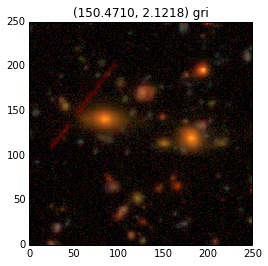

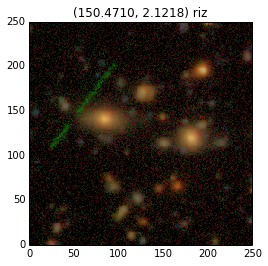

In [30]:
rgbFileFmt = "foo-%s.png" if False else None
min = -0.0
max = 0.4
Q = 12

for bands in ["gri", "riz",]:  # "izy"
    B, G, R = bands
    if True:
        rgb = afwRgb.makeRGB(images[R].getImage(), images[G].getImage(), images[B].getImage(), min, max - min, Q)
    else:        
        #afwRgb.replaceSaturatedPixels(images[R], images[G], images[B], 1, 1e4)

        ims = images[R].getImage(), images[G].getImage(), images[B].getImage()
        rgb = afwRgb.AsinhZScaleMapping(ims, Q=12).makeRgbImage(*ims) #, xSize=1000)
    
    plt = afwRgb.displayRGB(rgb, show=False)
    plt.title("(%.4f, %.4f) %s" % (ra, dec, bands))
    plt.show()
    
    if rgbFileFmt:
        afwRgb.writeRGB(rgbFileFmt % bands, rgb)